# Ordinal Encoding with Titanic

In this notebook, we implement ordinal encoding to the column "Cabin" in the Titanic dataset. The column has been initially "engineered" so that only the first letter remains. Then, the order of the categories is manually defined, alphabetically, starting at "T' (the boat deck), then from 'A" to "G", and ultimatelly with "N_A" (the replacement for null values). (Or reversed; the relative order being more important than absolute order.)

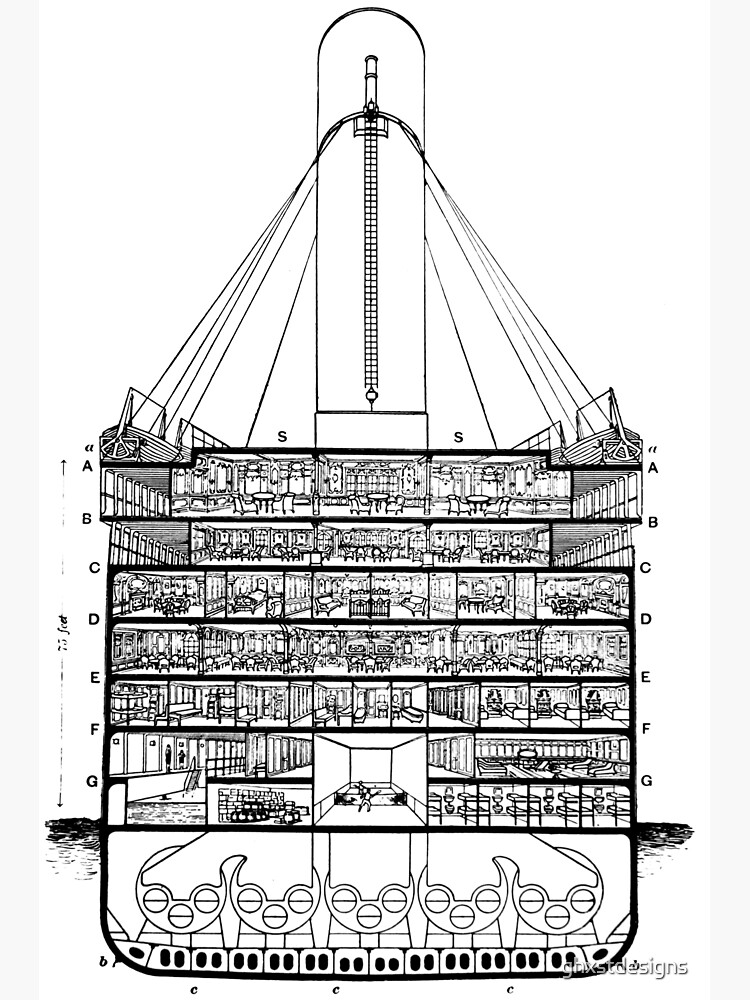

With this choice of preprocessing, we achieve a more compact dataset (fewer columns created with one-hot encoding), although our pipeline gets more complex: the categorical branch will contain now the SimpleImputer, followed by a ColumnTransformer that branches into One Hot and Ordinal encoding.

A common error is trying to use a ColumnTransformer after the column names have been lost in a previous pipeline step (in our case, the SimpleImputer). This can be solved either using a pandas method instead of a sklearn transformer (e.g. `df.fill_na`), wrapped in a FunctionTransformer, as we will demonstrate in the sample solution for the Housing dataset, or by passing the indeces instead of the column names to the ColumnTransformer, as we show here.

## 1. Reading, cleaning & splitting

In [2]:
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import set_config

# reading
url = "https://drive.google.com/file/d/1g3uhw_y3tboRm2eYDPfUzXXsw8IOYDCy/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = df = pd.read_csv(path)

# X and y creation
X = data.drop(columns=["PassengerId", "Name", "Ticket"])
y = X.pop("Survived")

# Feature Engineering
X.loc[:, "Cabin"] = X.Cabin.str[0]

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## 2. Building the `preprocessor`

We have included all the code to create the preprocessing pipeline in a single cell for compactness. Take your time to understand what's going on. If needed, create multiple cells and bring the code there step by step, analyzing the output each time. Writing a sketch of the pipeline with pen an paper is also a good idea.

In [3]:
# 0. Set the config so that we can view our preprocessor, and to transform output from numpy arrays to pandas dataframes
set_config(display="diagram")
set_config(transform_output="pandas")

# 1. defining categorical & numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

# 3. categorical pipeline

# # 3.1 defining ordinal & onehot columns
# .get_indexer() get's the index to solve the problem described above about losing column names
ordinal_cols = ["Cabin"]
onehot_cols = ["Sex", "Embarked"]

# # 3.2. defining the categorical encoder

# # # 3.2.1. we manually establish the order of the categories for our ordinal feature (Cabin), including "N_A"
cabin_cats = ["N_A", "G", "F", "E", "D", "C", "B", "A", "T"]


# # # 3.2.2. defining the categorical encoder: a ColumnTransformer with 2 branches: ordinal & onehot
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=[cabin_cats]), ordinal_cols),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_cols),
    ]
)

# # 3.3. categorical pipeline = "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 categorical_encoder
                                )

# 4. full preprocessing: a ColumnTransformer with 2 branches: numeric & categorical
full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categorical_pipe, X_cat.columns),
    ]
)

full_preprocessing

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                ('cat_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N_A',
                                                                strategy='constant')),
                                                 ('columntransformer',
                                                  ColumnTransformer(transformers=[('cat_ordinal',
                                                                                   OrdinalEncoder(categories=[['N_A',
                                                                                                               'G',
                                                                                                               'F',
                                                                                                               'E',
                                                                                                               'D',
                                                                                                               'C',
                                                                                                               'B',
                                                                                                               'A',
                                                                                                               'T']]),
                                                                                   ['Cabin']),
                                                                                  ('cat_onehot',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['Sex',
                                                                                    'Embarked'])]))]),
                                 Index(['Sex', 'Cabin', 'Embarked'], dtype='object'))])

## 3. Decision Tree

In [6]:
from sklearn.model_selection import GridSearchCV

# full pipeline: preprocessor + model
full_pipeline = make_pipeline(full_preprocessing,
                              DecisionTreeClassifier())

# define parameter grid
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

# define GridSearchCV
search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)

search.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


np.float64(0.8061558160149709)

Passthrough on column

In [7]:
imputer = SimpleImputer()
encoder = OneHotEncoder()
tree = DecisionTreeClassifier()

X_categorical_1 = ['Embarked']
X_categorical_2 = ['Cabin']

column_transformer = make_column_transformer(
    (encoder, X_categorical_2)
    #, remainder='passthrough'
)
column_transformer2 = make_column_transformer(
    (encoder, X_categorical_1)
    , remainder='passthrough'
)
column_transformer3 = make_column_transformer(
    (encoder, X_categorical_1)
    , ('remainder', X_categorical_2)
)
column_transformer4 = make_column_transformer(
    (encoder, X_categorical_1 + X_categorical_2)
)

pipe = make_pipeline(
    SimpleImputer(),
    column_transformer,
    column_transformer2,
    column_transformer3,
    column_transformer4,
    DecisionTreeClassifier()
)
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('columntransformer-1',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Cabin'])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Embarked'])])),
                ('columntransformer-3',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Embarked']),
                                                 ('remainder', 'remainder',
                                                  ['Cabin'])])),
                ('columntransformer-4',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Embarked', 'Cabin'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

## **Your challenge**

In a new notebook, apply everything you have learned here to the Housing project, following the Learning platform.

### Libraries and data

In [1]:
import pandas as pd
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

set_config(transform_output='pandas')

# reading
data = pd.read_csv('data/housing_iteration_4_classification.zip')
data = data.drop_duplicates()

# X and y creation
X = data
y = X.pop('Expensive')

# # Feature Engineering
# X.loc[:, 'Cabin'] = X.Cabin.str[0]

# # data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=123)

In [2]:
# selecting non-numerical columns
X_categorical = X_train.select_dtypes(exclude='number').columns
X_numerical = X_train.select_dtypes(include='number').columns

X_categorical_idx = X_train.columns.get_indexer(X_categorical)
X_numerical_idx = X_train.columns.get_indexer(X_numerical)

#### Sort categorical columns

In [3]:
mszoning_order = ['RP', 'RL', 'RM', 'RH', 'FV', 'C (all)', 'A', 'I']		
# MSZoning: Identifies the general zoning classification of the sale.
#     A	Agriculture
#     C	Commercial
#     FV	Floating Village Residential
#     I	Industrial
#     RH	Residential High Density
#     RL	Residential Low Density
#     RP	Residential Low Density Park 
#     RM	Residential Medium Density
X['MSZoning'].value_counts()

MSZoning
RL         1151
RM          212
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [4]:
condition1_order = ['PosA', 'PosN', 'Norm', 'Artery', 'Feedr', ['RRAn', 'RRAe'], ['RRNn', 'RRNe']]
condition1_order = ['PosA', 'PosN', 'Norm', 'Artery', 'Feedr', 'RRAn', 'RRAe', 'RRNn', 'RRNe']
# Condition1: Proximity to various conditions
#     Artery	Adjacent to arterial street
#     Feedr	Adjacent to feeder street	
#     Norm	Normal	
#     RRNn	Within 200' of North-South Railroad
#     RRAn	Adjacent to North-South Railroad
#     PosN	Near positive off-site feature--park, greenbelt, etc.
#     PosA	Adjacent to postive off-site feature
#     RRNe	Within 200' of East-West Railroad
#     RRAe	Adjacent to East-West Railroad
X['Condition1'].value_counts()

Condition1
Norm      1254
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: count, dtype: int64

In [5]:
heating_order = ['GasW', 'OthW', 'GasA', 'Floor', 'Wall', 'Grav']
# Heating: Type of heating
#     Floor	Floor Furnace
#     GasA	Gas forced warm air furnace
#     GasW	Gas hot water or steam heat
#     Grav	Gravity furnace	
#     OthW	Hot water or steam heat other than gas
#     Wall	Wall furnace
X['Heating'].value_counts()

Heating
GasA     1422
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: count, dtype: int64

In [6]:
street_order = ['Pave', 'Grvl']
# Street: Type of road access to property
#        Grvl	Gravel	
#        Pave	Paved
X['Street'].value_counts()

Street
Pave    1448
Grvl       6
Name: count, dtype: int64

In [7]:
centralair_order = ['Y', 'N']
# CentralAir: Central air conditioning
#        N	No
#        Y	Yes
X['CentralAir'].value_counts()

CentralAir
Y    1359
N      95
Name: count, dtype: int64

In [8]:
foundation_order = ['PConc', 'CBlock', 'BrkTil', 'Stone', 'Slab', 'Wood']
# Foundation: Type of foundation
#        BrkTil	Brick & Tile
#        CBlock	Cinder Block
#        PConc	Poured Contrete	
#        Slab	Slab
#        Stone	Stone
#        Wood	Wood
X['Foundation'].value_counts()

Foundation
PConc     642
CBlock    633
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64

In [9]:
exterqual_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
# ExterQual: Evaluates the quality of the material on the exterior 
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
X['ExterQual'].value_counts()

ExterQual
TA    903
Gd    485
Ex     52
Fa     14
Name: count, dtype: int64

In [10]:
extercond_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
# ExterCond: Evaluates the present condition of the material on the exterior
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
X['ExterCond'].value_counts()

ExterCond
TA    1276
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: int64

In [11]:
bsmtqual_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# BsmtQual: Evaluates the height of the basement
#        Ex	Excellent (100+ inches)	
#        Gd	Good (90-99 inches)
#        TA	Typical (80-89 inches)
#        Fa	Fair (70-79 inches)
#        Po	Poor (<70 inches
#        NA	No Basement
X['BsmtQual'].value_counts()

BsmtQual
TA    648
Gd    613
Ex    121
Fa     35
Name: count, dtype: int64

In [12]:
bsmtcond_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# BsmtCond: Evaluates the general condition of the basement
#        Ex	Excellent
#        Gd	Good
#        TA	Typical - slight dampness allowed
#        Fa	Fair - dampness or some cracking or settling
#        Po	Poor - Severe cracking, settling, or wetness
#        NA	No Basement
X['BsmtCond'].value_counts()

BsmtCond
TA    1305
Gd      65
Fa      45
Po       2
Name: count, dtype: int64

In [13]:
bsmtexposure_order = ['Gd', 'Av', 'Mn', 'No', 'NA']
# BsmtExposure: Refers to walkout or garden level walls
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement
X['BsmtExposure'].value_counts()

BsmtExposure
No    950
Av    220
Gd    132
Mn    114
Name: count, dtype: int64

In [14]:
bsmtfintype1_order = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
# BsmtFinType1: Rating of basement finished area
#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement
X['BsmtFinType1'].value_counts()

BsmtFinType1
Unf    428
GLQ    415
ALQ    219
BLQ    148
Rec    133
LwQ     74
Name: count, dtype: int64

In [15]:
kitchenqual_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
# KitchenQual: Kitchen quality
#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
X['KitchenQual'].value_counts()

KitchenQual
TA    732
Gd    583
Ex    100
Fa     39
Name: count, dtype: int64

In [16]:
fireplacequ_order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
# FireplaceQu: Fireplace quality
#        Ex	Excellent - Exceptional Masonry Fireplace
#        Gd	Good - Masonry Fireplace in main level
#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#        Fa	Fair - Prefabricated Fireplace in basement
#        Po	Poor - Ben Franklin Stove
#        NA	No Fireplace
X['FireplaceQu'].value_counts()

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

### Knowing data

In [17]:
data.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,CentralAir,Foundation,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,KitchenQual,FireplaceQu
0,8450,65.0,856,3,0,0,2,0,0,RL,...,Y,PConc,Gd,TA,Gd,TA,No,GLQ,Gd,NaN
1,9600,80.0,1262,3,1,0,2,298,0,RL,...,Y,CBlock,TA,TA,Gd,TA,Gd,ALQ,TA,TA
2,11250,68.0,920,3,1,0,2,0,0,RL,...,Y,PConc,Gd,TA,Gd,TA,Mn,GLQ,Gd,TA
3,9550,60.0,756,3,1,0,3,0,0,RL,...,Y,BrkTil,TA,TA,TA,Gd,No,ALQ,Gd,Gd
4,14260,84.0,1145,4,1,0,3,192,0,RL,...,Y,PConc,Gd,TA,Gd,TA,Av,GLQ,Gd,TA


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1454 entries, 0 to 1459
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       1454 non-null   int64  
 1   LotFrontage   1196 non-null   float64
 2   TotalBsmtSF   1454 non-null   int64  
 3   BedroomAbvGr  1454 non-null   int64  
 4   Fireplaces    1454 non-null   int64  
 5   PoolArea      1454 non-null   int64  
 6   GarageCars    1454 non-null   int64  
 7   WoodDeckSF    1454 non-null   int64  
 8   ScreenPorch   1454 non-null   int64  
 9   MSZoning      1454 non-null   object 
 10  Condition1    1454 non-null   object 
 11  Heating       1454 non-null   object 
 12  Street        1454 non-null   object 
 13  CentralAir    1454 non-null   object 
 14  Foundation    1454 non-null   object 
 15  ExterQual     1454 non-null   object 
 16  ExterCond     1454 non-null   object 
 17  BsmtQual      1417 non-null   object 
 18  BsmtCond      1417 non-null   obj

In [19]:
X_numerical

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')

In [20]:
X_categorical

Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu'],
      dtype='object')

In [21]:
X_train

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,CentralAir,Foundation,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,KitchenQual,FireplaceQu
547,7244,54.0,768,2,0,0,2,104,0,RL,...,Y,CBlock,TA,Gd,Gd,TA,Av,ALQ,TA,NaN
950,7200,60.0,864,3,0,0,2,194,0,RL,...,Y,CBlock,TA,TA,TA,TA,No,ALQ,Gd,NaN
275,7264,55.0,952,3,0,0,2,74,144,RL,...,N,BrkTil,Gd,Gd,TA,TA,No,Unf,Ex,NaN
1301,7500,NaN,771,3,2,0,1,0,224,RL,...,Y,CBlock,TA,TA,TA,TA,No,BLQ,Gd,Gd
1295,8400,70.0,1052,3,0,0,1,356,0,RL,...,Y,CBlock,TA,TA,TA,TA,Av,BLQ,TA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,4800,40.0,1196,2,0,0,2,0,0,RM,...,Y,CBlock,TA,TA,TA,TA,No,LwQ,TA,NaN
943,25000,100.0,1632,4,0,0,2,0,0,RL,...,Y,CBlock,TA,TA,TA,TA,Av,Unf,TA,NaN
1113,8923,66.0,1008,2,0,0,1,0,0,RL,...,Y,CBlock,TA,TA,TA,TA,No,BLQ,Gd,NaN
479,5925,50.0,907,2,0,0,2,0,0,RM,...,Y,BrkTil,TA,TA,Fa,TA,No,Rec,TA,NaN


### Transformers

In [22]:
X_numerical

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')

In [23]:
pipe_numerical = Pipeline([('simple_imputer', SimpleImputer())])
pipe_categorical = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='NA'))
    , ('order_encoder', OrdinalEncoder(categories=[
    mszoning_order, condition1_order, heating_order, street_order, centralair_order
    , foundation_order, exterqual_order, extercond_order, bsmtqual_order, bsmtcond_order
    , bsmtexposure_order, bsmtfintype1_order, kitchenqual_order, fireplacequ_order]))])

pipes = ColumnTransformer([
    ('num_imputer1', pipe_numerical, ['LotArea'])
    ,('num_imputer2', pipe_numerical, ['LotFrontage'])
    ,('num_imputer3', pipe_numerical, ['TotalBsmtSF'])
    ,('num_imputer4', pipe_numerical, ['BedroomAbvGr'])
    ,('num_imputer5', pipe_numerical, ['Fireplaces'])
    ,('num_imputer6', pipe_numerical, ['PoolArea'])
    ,('num_imputer7', pipe_numerical, ['GarageCars'])
    ,('num_imputer8', pipe_numerical, ['WoodDeckSF'])
    ,('num_imputer9', pipe_numerical, ['ScreenPorch'])
    , ('cat_imputer_order', pipe_categorical, X_categorical)
])# , remainder='passthrough')
pipeline = Pipeline([('preprocessor', pipes), ('classifier', DecisionTreeClassifier())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer())]),
                                                  ['LotArea']),
                                                 ('num_imputer2',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage']),
                                                 ('num_imputer3',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer())]),
                                                  ['TotalBsmtSF']),
                                                 ('num_imputer4',
                                                  Pipeline(steps=[...
                                                                                               'NA'],
                                                                                              ['GLQ',
                                                                                               'ALQ',
                                                                                               'BLQ',
                                                                                               'Rec',
                                                                                               'LwQ',
                                                                                               'Unf',
                                                                                               'NA'],
                                                                                              ['Ex',
                                                                                               'Gd',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Po'],
                                                                                              ['Ex',
                                                                                               'Gd',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Po',
                                                                                               'NA']]))]),
                                                  Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu'],
      dtype='object'))])),
                ('classifier', DecisionTreeClassifier())])

In [24]:
pipeline.named_steps['preprocessor'].fit_transform(X_train).columns

Index(['num_imputer1__LotArea', 'num_imputer2__LotFrontage',
       'num_imputer3__TotalBsmtSF', 'num_imputer4__BedroomAbvGr',
       'num_imputer5__Fireplaces', 'num_imputer6__PoolArea',
       'num_imputer7__GarageCars', 'num_imputer8__WoodDeckSF',
       'num_imputer9__ScreenPorch', 'cat_imputer_order__MSZoning',
       'cat_imputer_order__Condition1', 'cat_imputer_order__Heating',
       'cat_imputer_order__Street', 'cat_imputer_order__CentralAir',
       'cat_imputer_order__Foundation', 'cat_imputer_order__ExterQual',
       'cat_imputer_order__ExterCond', 'cat_imputer_order__BsmtQual',
       'cat_imputer_order__BsmtCond', 'cat_imputer_order__BsmtExposure',
       'cat_imputer_order__BsmtFinType1', 'cat_imputer_order__KitchenQual',
       'cat_imputer_order__FireplaceQu'],
      dtype='object')

In [25]:
pipeline.named_steps#['preprocessor']

{'preprocessor': ColumnTransformer(transformers=[('num_imputer1',
                                  Pipeline(steps=[('simple_imputer',
                                                   SimpleImputer())]),
                                  ['LotArea']),
                                 ('num_imputer2',
                                  Pipeline(steps=[('simple_imputer',
                                                   SimpleImputer())]),
                                  ['LotFrontage']),
                                 ('num_imputer3',
                                  Pipeline(steps=[('simple_imputer',
                                                   SimpleImputer())]),
                                  ['TotalBsmtSF']),
                                 ('num_imputer4',
                                  Pipeline(steps=[('simple_imputer',
                                                   SimpleImputer(...
                                                                          

### Grid search

In [26]:
# # define parameter grid
# param_grid = {
#     'preprocessor__num_imputer1__simple_imputer__strategy':['mean']
#     , 'preprocessor__num_imputer2__simple_imputer__strategy':['mean']
#     , 'preprocessor__num_imputer3__simple_imputer__strategy':['median']
#     , 'preprocessor__num_imputer4__simple_imputer__strategy':['mean']
#     , 'preprocessor__num_imputer5__simple_imputer__strategy':['mean']
#     , 'preprocessor__num_imputer6__simple_imputer__strategy':['mean']
#     , 'preprocessor__num_imputer7__simple_imputer__strategy':['mean']
#     , 'preprocessor__num_imputer8__simple_imputer__strategy':['mean']
#     , 'preprocessor__num_imputer9__simple_imputer__strategy':['mean']
#     , 'classifier__max_depth': range(4, 7, 1)
#     , 'classifier__min_samples_leaf': range(2, 4, 1)
#     , 'classifier__min_samples_split': range(2, 4, 1)
#     , 'classifier__criterion': ['gini', 'entropy']
    
# }

# # define GridSearchCV
# param_search = GridSearchCV(pipeline,
#                       param_grid,
#                       cv=5,
#                       verbose=1)

# param_search.fit(X_train, y_train)

# param_search.best_params_

In [27]:
# best = param_search.best_estimator_
# best.fit(X_train, y_train)
# y_pred = best.predict(X_train)
# accuracy_score(y_true = y_train, y_pred = y_pred)

### Test best fit

In [28]:
# best = param_search.best_estimator_
# best.fit(X_test, y_test)
# y_pred = best.predict(X_test)
# accuracy_score(y_true = y_test, y_pred = y_pred)

### Error analysis

In [29]:
# ConfusionMatrixDisplay.from_estimator(
#     best
#     , X_test
#     , y_test
#     , display_labels=['Not expensive', 'Expensive']);

In [30]:
# print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
# print(f'Recall: {recall_score(y_test, y_pred):.4f}')
# print(f'Precision: {precision_score(y_test, y_pred):.4f}')
# print(f'F1 score: {f1_score(y_test, y_pred):.4f}')

### Classifier pick

In [31]:
pipe_numerical = Pipeline([('simple_imputer', SimpleImputer())])
pipe_categorical = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='NA'))
    , ('order_encoder', OrdinalEncoder(categories=[
    mszoning_order, condition1_order, heating_order, street_order, centralair_order
    , foundation_order, exterqual_order, extercond_order, bsmtqual_order, bsmtcond_order
    , bsmtexposure_order, bsmtfintype1_order, kitchenqual_order, fireplacequ_order]))])
classifiers = [
    ("decision_tree", DecisionTreeClassifier()),
    ("random_forest", RandomForestClassifier()),
    ("logistic_regression", LogisticRegression())
]

pipes = ColumnTransformer([
    ('num_imputer1', SimpleImputer(strategy='mean'), ['LotArea'])
    ,('num_imputer2', SimpleImputer(strategy='mean'), ['LotFrontage'])
    ,('num_imputer3', pipe_numerical, ['TotalBsmtSF'])
    ,('num_imputer4', SimpleImputer(strategy='mean'), ['BedroomAbvGr'])
    ,('num_imputer5', SimpleImputer(strategy='mean'), ['Fireplaces'])
    ,('num_imputer6', SimpleImputer(strategy='mean'), ['PoolArea'])
    ,('num_imputer7', SimpleImputer(strategy='mean'), ['GarageCars'])
    ,('num_imputer8', SimpleImputer(strategy='mean'), ['WoodDeckSF'])
    ,('num_imputer9', SimpleImputer(strategy='mean'), ['ScreenPorch'])
    , ('cat_imputer_order', pipe_categorical, X_categorical)
])# , remainder='passthrough')
pipeline = Pipeline([('preprocessor', pipes), ('classifier', DecisionTreeClassifier())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer1',
                                                  SimpleImputer(),
                                                  ['LotArea']),
                                                 ('num_imputer2',
                                                  SimpleImputer(),
                                                  ['LotFrontage']),
                                                 ('num_imputer3',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer())]),
                                                  ['TotalBsmtSF']),
                                                 ('num_imputer4',
                                                  SimpleImputer(),
                                                  ['BedroomAbvGr']),
                                                 ('num_imputer5',
                                                  SimpleImputer(),
                                                  ['Fireplaces']),
                                                 ('num_im...
                                                                                               'NA'],
                                                                                              ['GLQ',
                                                                                               'ALQ',
                                                                                               'BLQ',
                                                                                               'Rec',
                                                                                               'LwQ',
                                                                                               'Unf',
                                                                                               'NA'],
                                                                                              ['Ex',
                                                                                               'Gd',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Po'],
                                                                                              ['Ex',
                                                                                               'Gd',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Po',
                                                                                               'NA']]))]),
                                                  Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu'],
      dtype='object'))])),
                ('classifier', DecisionTreeClassifier())])

In [32]:
# define parameter grid
param_grid = [
    {
        'preprocessor__num_imputer3__simple_imputer__strategy':['mean', 'median']
        , 'classifier': [DecisionTreeClassifier()]
        ,'classifier__max_depth': range(4, 7, 1)
        , 'classifier__min_samples_leaf': range(2, 4, 1)
        , 'classifier__min_samples_split': range(2, 4, 1)
        , 'classifier__criterion': ['gini', 'entropy']}

    # Parameters for Random Forest
    , {
        'preprocessor__num_imputer3__simple_imputer__strategy':['mean', 'median']
        , 'classifier': [RandomForestClassifier()]
        , 'classifier__n_estimators': range(290, 400, 10)#[250, 300, 350]
        , 'classifier__max_features': ["auto", "sqrt", "log2"]}

    # Parameters for Logistic Regression
    # , {'classifier': [LogisticRegression()]
    #     , 'classifier__C': [0.1, 1, 10]
    #     , 'classifier__solver': ["liblinear", "lbfgs"]}
]

# define GridSearchCV
param_search = GridSearchCV(pipeline,
                      param_grid,
                      cv=StratifiedKFold(n_splits=5),
                      verbose=1)

param_search.fit(X_train, y_train)

param_search.best_params_

Fitting 5 folds for each of 114 candidates, totalling 570 fits


c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
110 fits failed out of a total of 570.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gastan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Gastan

{'classifier': RandomForestClassifier(),
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 300,
 'preprocessor__num_imputer3__simple_imputer__strategy': 'median'}

In [33]:
param_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_imputer1',
                                                  SimpleImputer(),
                                                  ['LotArea']),
                                                 ('num_imputer2',
                                                  SimpleImputer(),
                                                  ['LotFrontage']),
                                                 ('num_imputer3',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['TotalBsmtSF']),
                                                 ('num_imputer4',
                                                  SimpleImputer(),
                                                  ['BedroomAbvGr']),
                                                 ('num_imputer5',
                                                  SimpleImputer(),
                                                  ['Firep...
                                                                                               'BLQ',
                                                                                               'Rec',
                                                                                               'LwQ',
                                                                                               'Unf',
                                                                                               'NA'],
                                                                                              ['Ex',
                                                                                               'Gd',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Po'],
                                                                                              ['Ex',
                                                                                               'Gd',
                                                                                               'TA',
                                                                                               'Fa',
                                                                                               'Po',
                                                                                               'NA']]))]),
                                                  Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(n_estimators=300))])

In [56]:
best = param_search.best_estimator_
best.fit(X_train, y_train)
y_train_pred = best.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train, y_train_pred):.4f}')
print(f'Recall: {recall_score(y_train, y_train_pred):.4f}')
print(f'Precision: {precision_score(y_train, y_train_pred):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_pred):.4f}')

Accuracy: 1.0000
Recall: 1.0000
Precision: 1.0000
F1 score: 1.0000


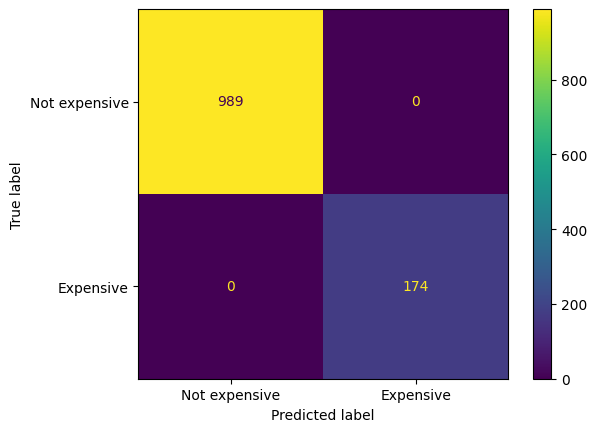

In [55]:
ConfusionMatrixDisplay.from_estimator(
    best
    , X_train
    , y_train_pred
    , display_labels=['Not expensive', 'Expensive']);

In [57]:
best = param_search.best_estimator_
best.fit(X_test, y_test)
y_test_pred = best.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_test_pred):.4f}')

Accuracy: 1.0000
Recall: 1.0000
Precision: 1.0000
F1 score: 1.0000


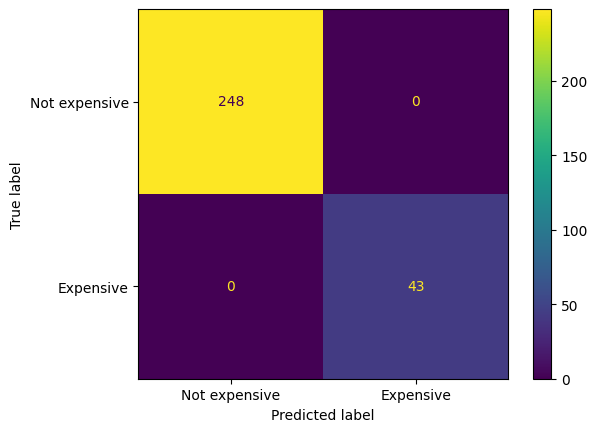

In [58]:
ConfusionMatrixDisplay.from_estimator(
    best
    , X_test
    , y_test_pred
    , display_labels=['Not expensive', 'Expensive']);